In [ ]:
import tensorflow

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
tensorflow.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [ ]:
# 이미지 처리
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# 파일 존재 여부 확인용
import os

In [ ]:
# 모델
from tensorflow import keras
from keras_segmentation.models.model_utils import get_segmentation_model

# 변수 목록

In [ ]:
train_dir_name = "./Train-Validation/Train/"
val_dir_name = "./Train-Validation/Validation/"

img_width = 200
img_height = 200

model_dir_name = './Model/' # 학습 모델이 저장될 디렉토리명

## 모델 이름은 안바꿔주면 이전 모델에 덮어쓰기되니까 잊지말고 꼭 바꿔주자

In [ ]:
model_path = model_dir_name + 'poly_seg_model_0104_02.keras'

# Train 데이터와 Validation 데이터 불러오기

In [ ]:
x_train = []
y_train = []

for i in range(0, 801):
    img_path = train_dir_name + "Image/" + str(i) + ".jpg"
    label_path = train_dir_name + "Annotation/" + str(i) + ".png"

    if not os.path.isfile(img_path):
        continue
    if not os.path.isfile(label_path):
        continue

    # 이미지 파일 로드
    img_file = cv2.imread(img_path)
    if img_file is None:
        print(str(i) + ".jpg File Load Failed!!")
        break

    # 라벨링 파일 로드
    label_file = np.asarray(Image.open(label_path))
    if label_file is None:
        print(str(i) + ".png File Load Failed!!")

    x_train.append(img_file)
    y_train.append(label_file)


    if len(y_train)%500 == 0: # 진행도 확인용
        print(str(len(y_train)) + "개 파일 읽기 완료")


print("Complete")


500개 파일 읽기 완료
Complete


In [ ]:
x_val = []
y_val = []

for i in range(0, 201):
    img_path = val_dir_name + "Image/" + str(i) + ".jpg"
    label_path = val_dir_name + "Annotation/" + str(i) + ".png"

    if not os.path.isfile(img_path):
        continue
    if not os.path.isfile(label_path):
        continue

    # 이미지 파일 로드
    img_file = cv2.imread(img_path)
    if img_file is None:
        print(str(i) + ".jpg File Load Failed!!")
        break

    # 라벨링 파일 로드
    label_file = np.asarray(Image.open(label_path))
    if label_file is None:
        print(str(i) + ".png File Load Failed!!")

    x_val.append(img_file)
    y_val.append(label_file)


    if len(y_val)%500 == 0: # 진행도 확인용
        print(str(len(y_val)) + "개 파일 읽기 완료")


print("Complete")


Complete


In [ ]:
x_train = np.array(x_train)
x_train.shape

(800, 200, 200, 3)

In [ ]:
y_train = np.array(y_train)
y_train.shape

(800, 200, 200)

In [ ]:
x_val = np.array(x_val)
x_val.shape

(200, 200, 200, 3)

In [ ]:
y_val = np.array(y_val)
y_val.shape

(200, 200, 200)

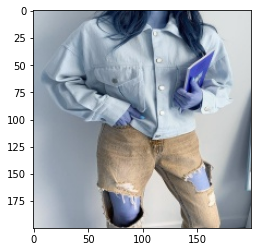

In [ ]:
plt.imshow(x_train[0])
plt.show()

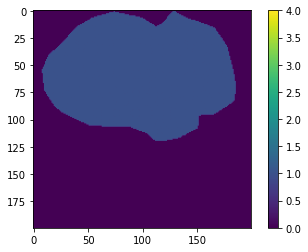

In [ ]:
plt.imshow(y_train[0])
plt.clim(0, 4)
plt.colorbar()
plt.show()

# 모델 생성

In [ ]:
input_img = keras.layers.Input(shape=(img_height, img_width, 3))

conv1 = keras.layers.Conv2D(filters=32, kernel_size=5, padding='same', activation='relu')(input_img)
pool1 = keras.layers.MaxPooling2D(2)(conv1)
pool1 = keras.layers.Dropout(0.2)(pool1)

conv2 = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(pool1)
pool2 = keras.layers.MaxPooling2D(2)(conv2)
poo12 = keras.layers.Dropout(0.3)(pool2)

conv3 = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(pool2)
conv3 = keras.layers.Dropout(0.4)(conv3)

# up1 = keras.layers.concatenate([keras.layers.Conv2DTranspose(filters=64, kernel_size=3)(conv3), conv2], axis=-1)
up1 = keras.layers.concatenate([keras.layers.UpSampling2D(2)(conv3), conv2], axis=-1)
conv4 = keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(up1)
conv4 = keras.layers.Dropout(0.3)(conv4)

# up2 = keras.layers.concatenate([keras.layers.Conv2DTranspose(filters=32, kernel_size=3)(conv4), conv1], axis=-1)
up2 = keras.layers.concatenate([keras.layers.UpSampling2D(2)(conv4), conv1], axis=-1)
conv5 = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(up2)
conv5 = keras.layers.Dropout(0.2)(conv5)

output_img = keras.layers.Conv2D(filters=5, kernel_size=1, padding='same', name='OutputLayer')(conv5)


# poly_seg_model = get_segmentation_model(input_img, output_img)
poly_seg_model = keras.Model(input_img, output_img)
poly_seg_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
poly_seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 200, 200, 32)         2432      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 dropout (Dropout)           (None, 100, 100, 32)         0         ['max_pooling2d[0][0]']   

# 모델 학습

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
history = poly_seg_model.fit(x_train, y_train,
                             epochs=20, verbose=1,
                             validation_data=(x_val, y_val),
                             callbacks=[checkpoint_cb, early_stopping_cb])

print()
print("Complete")

Epoch 1/20
250/250 [==============================] - 2922s 12s/step - loss: 1.6657 - sparse_categorical_accuracy: 0.4457 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.7163
Epoch 2/20
250/250 [==============================] - 2918s 12s/step - loss: 1.6295 - sparse_categorical_accuracy: 0.5642 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.7345
Epoch 3/20
250/250 [==============================] - 2913s 12s/step - loss: 1.6285 - sparse_categorical_accuracy: 0.5967 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.7345
Epoch 4/20
250/250 [==============================] - 2913s 12s/step - loss: 1.6314 - sparse_categorical_accuracy: 0.2283 - val_loss: 1.6094 - val_sparse_categorical_accuracy: 0.0681


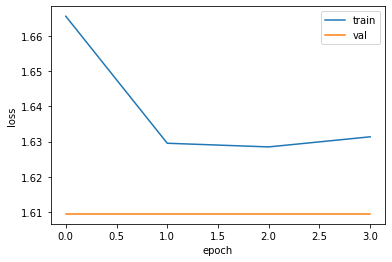

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 모델 테스트

## Validation 데이터 일부의 predict 결과 확인

In [ ]:
saved_model_path = model_dir_name + 'poly_seg_model_0104_02.keras'

saved_model = keras.models.load_model(saved_model_path)

In [ ]:
preds = saved_model.predict(x_val[0:1])
type(preds)

1/1 [==============================] - 0s 113ms/step


numpy.ndarray

In [ ]:
preds.shape

(1, 200, 200, 5)

In [ ]:
pred_mask = preds.argmax(axis=-1)
pred_mask.shape

(1, 200, 200)

In [ ]:
np.unique(pred_mask[0])

array([0, 4])

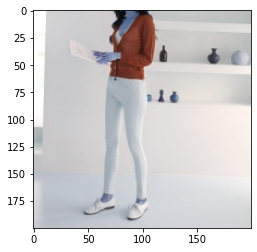

In [ ]:
plt.imshow(x_val[0])
plt.show()

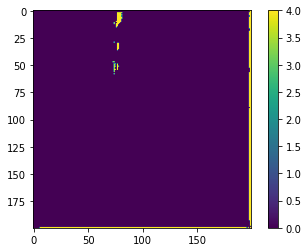

In [ ]:
plt.imshow(pred_mask[0])
plt.clim(0, 4)
plt.colorbar()
plt.show()

In [ ]:
x_val_rgb = cv2.cvtColor(x_val[0], cv2.COLOR_BGR2RGB) # RGB를 RGB 색공간으로 변경

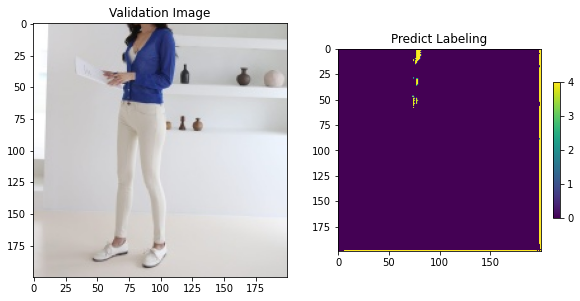

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(x_val_rgb)
plt.title("Validation Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask[0])
plt.clim(0, 4)
plt.colorbar(shrink=0.5)
plt.title("Predict Labeling")

plt.show()

In [ ]:
acc = keras.metrics.SparseCategoricalAccuracy()
acc.reset_state()
acc.update_state(pred_mask[0], y_val[0:1])
acc.result().numpy()

0.1149

## 남성 모델 이미지의 predict 결과 확인

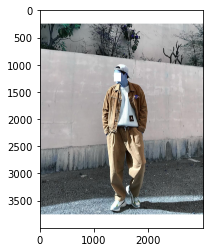

In [ ]:
man_img_path = '/home/ubuntu/manImage/010.연도별_패션_선호도_파악_및_추천_데이터/01-1.정식개방데이터/Training/01.원천데이터/2019/T_00003_19_normcore_M.jpg'

man_img = cv2.imread(man_img_path)
if man_img is None:
    print('Image File Load Failed!!')
else:
    plt.imshow(man_img)
    plt.show()

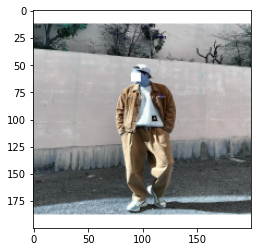

In [ ]:
man_img_resize = cv2.resize(man_img, dsize=(img_height, img_width), interpolation=cv2.INTER_AREA)
plt.imshow(man_img_resize)
plt.show()

In [ ]:
man_img_res_array = np.array([man_img_resize])
man_img_res_array.shape

(1, 200, 200, 3)

In [ ]:
preds = saved_model.predict(man_img_res_array[:])
type(preds)

1/1 [==============================] - 0s 116ms/step


numpy.ndarray

In [ ]:
preds.shape

(1, 200, 200, 5)

In [ ]:
pred_mask = preds.argmax(axis=-1)
pred_mask.shape

(1, 200, 200)

In [ ]:
np.unique(pred_mask[0])

array([0, 4])

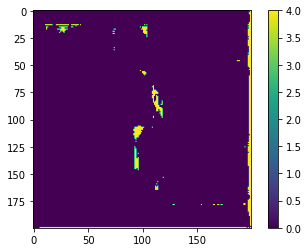

In [ ]:
plt.imshow(pred_mask[0])
plt.clim(0, 4)
plt.colorbar()
plt.show()

In [ ]:
man_img_resize_rgb = cv2.cvtColor(man_img_resize, cv2.COLOR_BGR2RGB) # RGB를 RGB 색공간으로 변경

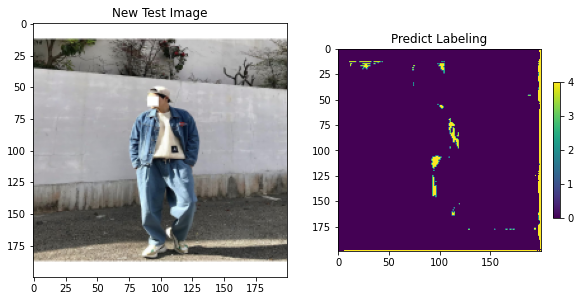

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(man_img_resize_rgb)
plt.title("New Test Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask[0])
plt.clim(0, 4)
plt.colorbar(shrink=0.5)
plt.title("Predict Labeling")

plt.show()